In [35]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import conll2000
nltk.download("conll2000")
import nltk.stem.porter 
from nltk.classify import MaxentClassifier
import pickle
from gensim.models import Word2Vec
from collections import defaultdict
from nltk import ConfusionMatrix
from nltk.stem.porter import *
import string
from sklearn.metrics import confusion_matrix
import seaborn as sns

[nltk_data] Downloading package conll2000 to /home/ankita/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!


In [2]:
'''
Suffix nomenclature(not used but helpful in testing for extra features)
'''
NOUN_SUFFIX =['eer','er','ion','ity','ment','ness','or','tion','ship','th']
ADJ_SUFFIX = ['able','ible,','al','ant','ary','ful','ic','ious','ous','ive','less','y']
VERB_SUFFIX = ['ed','en','er','ing','ise','ize']
ADVERB_SUFFIX = ['ly','ward','wise']

In [3]:
def check_suffix(word,suffix):
    '''
    Utility function to check if a string in the array passed is a suffix or not
    '''
    val = False
    for s in suffix:
        val = val or word.endswith(s)
    return val

def output_pos_suffix(word):
    '''
    Output predicted part of speech based on suffixes
    '''
    if check_suffix(word,NOUN_SUFFIX):
        return "Noun"
    elif check_suffix(word,ADJ_SUFFIX):
        return "Adj"
    elif check_suffix(word,VERB_SUFFIX):
        return "Verb"
    elif check_suffix(word,ADVERB_SUFFIX):
        return "Adverb"
    else: 
        return "None"
    
    
stemmer = PorterStemmer()

def return_affix(word):
    word = word.lower()
    stem_word = stemmer.stem(word)          
    affix=word.split(stem_word)[-1]
    return affix

def is_capitalised(word):
    return word[0].upper() == word[0]

def all_capital(word):
    return word.upper() == word

def all_lower(word):
    return word.lower() == word


In [4]:
class MEMM_metrics():
    
    def __init__(self, test_actual_tags, test_predicted_tags):
        '''
        The test_actual_tags contains actual tags for the above setences.
        The test_predicted_tags contains predicted tags for the test data.
        '''
        self.counter_dict = defaultdict(lambda: defaultdict(lambda:0))
        self.test_actual_tags = test_actual_tags
        self.test_predicted_tags = test_predicted_tags
        self.tag_metrics = defaultdict(lambda: defaultdict(lambda:0))
            
    def calc_tag_metrics(self):
        '''
        Calculate the per-POS accuracy for all the tags in the tag-set
        '''
        counter_dict = defaultdict(lambda: defaultdict(lambda:0))
        
        for i in range(len(self.test_actual_tags)):
            
            if(self.test_actual_tags[i] == self.test_predicted_tags[i]):
                counter_dict[self.test_actual_tags[i]]['TP'] += 1
            else:
                counter_dict[self.test_actual_tags[i]]['FN']    += 1
                counter_dict[self.test_predicted_tags[i]]['FP'] += 1
        
        
        for tag in counter_dict.keys():
            try:
                self.tag_metrics[tag]['Precision'] = counter_dict[tag]['TP']/(counter_dict[tag]['TP']+counter_dict[tag]['FP'])
                self.tag_metrics[tag]['Recall'] = counter_dict[tag]['TP']/(counter_dict[tag]['TP']+counter_dict[tag]['FN'])
                self.tag_metrics[tag]['F1_score'] = 2*(self.tag_metrics[tag]['Precision']*self.tag_metrics[tag]['Recall'])/(self.tag_metrics[tag]['Precision']+self.tag_metrics[tag]['Recall'])

            except ZeroDivisionError:
                continue               
        self.counter_dict =  counter_dict
        
    def generate_confusion_matrix(self):
        '''
        Generate confusion matrix for the particular fold
        '''
        CM = ConfusionMatrix(self.test_actual_tags ,self.test_predicted_tags)
        print(CM)
        
    def accuracy(self):
        '''
        Calculate average accuracy score
        '''
        TP =0
        FP =0
        for tag in self.counter_dict.keys():
            if (tag !='O'):
                TP += self.counter_dict[tag]['TP']
                FP += self.counter_dict[tag]['FP']
        
        return TP/(TP+FP)
        
        
    def print_sample(self):
        '''
        Prints a sample of n = 5 actual and predicted tagged sentences for reference
        '''
        for i in range(5):
            print("Actual :",self.test_actual_tags[i])
            print("Predicted :",self.test_predicted_tags[i])
        
    def get_tag_metrics(self):
        '''
        Prints the per POS precision,recall and F1 score of predicted tags
        '''
        
        print ("{:<10} {:<10} {:<10} {:<10}".format('TAG', 'PRECISION', 'RECALL','F1_SCORE'))
        
        for key in self.tag_metrics.keys():
            precision = str(round(self.tag_metrics[key]['Precision'], 2))
            recall    = str(round(self.tag_metrics[key]['Recall'], 2))
            F1_score  = str(round(self.tag_metrics[key]['F1_score'], 2))
            print ("{:<10} {:<10} {:<10} {:<10} ".format(key, precision,recall,F1_score))

In [5]:
'''
Reading data into data frame
'''
df_train = pd.read_csv('train.txt', sep=" ",header=None,skip_blank_lines=False, names=['word','POS_tag','Chunk_tag'])
df_test = pd.read_csv('test.txt', sep=" ",header=None,skip_blank_lines=False, names=['word','POS_tag','Chunk_tag'])

In [6]:
'''
Initial pre-processing
'''
df_train['Chunk_tag'] = df_train['Chunk_tag'].str.split("-", n = 1, expand = True) 
df_test['Chunk_tag']  = df_test['Chunk_tag'].str.split("-", n = 1, expand = True) 

In [7]:
'''
Adding extra row for train sentences for ease of processing
'''
df_train = pd.concat([pd.DataFrame([['EOS','EOS','O']],columns=df_train.columns),df_train],ignore_index=True)


In [9]:
'''
Generating features for MEMM
'''

df_train['prev_POS']= df_train['POS_tag'].shift(1)
df_train['prev_prev_POS']= df_train['POS_tag'].shift(2)
df_train['prev_word']= df_train['word'].shift(1)
df_train['prev_chunk_tag']= df_train['Chunk_tag'].shift(1)
df_train['prev_chunk_tag'] = df_train['prev_chunk_tag'].fillna('O')
df_train['Chunk_tag'] = df_train['Chunk_tag'].fillna('O')
df_train['next_POS']= df_train['POS_tag'].shift(-1)
df_train['next_next_POS']= df_train['POS_tag'].shift(-2)
df_train['stemmed_word'] = df_train['word'].apply(stemmer.stem)
df_train['all_capital'] = df_train['word'].apply(all_capital)
df_train['word_affix'] = df_train['word'].apply(return_affix)
df_train = df_train.fillna('EOS')

In [12]:
'''
Seggregating train data into X and Y
'''

df_X_train = df_train.drop(columns='Chunk_tag')
df_Y_train = df_train['Chunk_tag']

df_X_train.head(60)
#df_Y_train

In [14]:
'''
Training the MEMM Classifier on the set of features
'''
dic =df_X_train.to_dict('records')
feat =  [(dic[i],df_Y_train[i])for i in range(len(dic))]
maxent_classifier = MaxentClassifier.train(feat, max_iter=60)

  ==> Training (60 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -1.09861        0.167
             2          -0.43251        0.913
             3          -0.28038        0.937
             4          -0.21754        0.941
             5          -0.18416        0.944
             6          -0.16356        0.946
             7          -0.14955        0.948
             8          -0.13933        0.950
             9          -0.13151        0.951
            10          -0.12528        0.953
            11          -0.12016        0.954
            12          -0.11586        0.955
            13          -0.11217        0.956
            14          -0.10896        0.957
            15          -0.10613        0.958
            16          -0.10360        0.959
            17          -0.10133        0.959
            18          -0.09926        0.960
            19          -0.09737        0.961
  

In [15]:
'''
Dividing the test dataframe to a list of dataframes for each sentence 
'''
idx = [-1]+ df_test.index[df_test.isnull().all(1)].tolist() + [df_test.shape[0]]
list_of_test_dfs = [df_test.iloc[idx[n]+1:idx[n+1]] for n in range(len(idx)-1)]

In [16]:
'''
Adding relevent features as done in train and seggregating data (X) and Chunk tag (Y) values 
'''
test_sent_X =[]
test_sent_Y =[]
for dfz in list_of_test_dfs:
    dfk = pd.concat([pd.DataFrame([['EOS','EOS','O']],columns=dfz.columns),dfz],ignore_index=True)
    dfk = dfk.append(pd.DataFrame(([['EOS','EOS','O']]),columns=dfk.columns),ignore_index=True)
    dfk['prev_POS']= dfk['POS_tag'].shift(1)
    dfk['prev_prev_POS']= dfk['POS_tag'].shift(2)
    dfk['prev_word']= dfk['word'].shift(1)
    dfk['stemmed_word'] = dfk['word'].apply(stemmer.stem)
    dfk['word_affix'] = dfk['word'].apply(return_affix)
    dfk['all_capital'] = dfk['word'].apply(all_capital)
    dfk['next_POS']= dfk['POS_tag'].shift(-1)
    dfk['next_next_POS']= dfk['POS_tag'].shift(-2)
    dfk = dfk.fillna('EOS')
    df_test_X = dfk.drop(columns='Chunk_tag')
    df_test_Y= dfk['Chunk_tag']
    test_sent_X.append(df_test_X)
    test_sent_Y.append(df_test_Y)

In [18]:
def viterbi_one_pass(test_sent):
        '''
        Viterbi Algorithm applied to one sentence and corresponding states
        Modified from HMM POS 
        '''
        prob_state ={}
        sent_dict = test_sent.to_dict('records') #Converting test_Sent dataframe to dictionary
        initial_prob_added =  False
        # Storing initial probabilities for start of sentences first
        
        possible_tags = ['B','I','O']
        prob_state[1] = {}
        for tag in possible_tags:
            try:
                sent_dict[1]['prev_chunk_tag']='O'
                prob = maxent_classifier.prob_classify(sent_dict[1])
                if(tag=='I'):
                    prob_state[1][tag] = ['O',0]
                else:
                    prob_state[1][tag] = ['O',float(prob.prob(tag))]
            except KeyError: 
                print("error")
                                
        # Iterating through the rest of the sentence
        max_in_current_level =0
        for k in range(2,len(sent_dict)):
            prob_state[k] = {}
            prev_state  = list(prob_state[k-1].keys()) 
            curr_state  =  ['B','I','O']
            for tag in curr_state:                             
                all_states = []
                for pt in prev_state: 
                    sent_dict[k]['prev_chunk_tag']= prev_state[max_in_current_level]
                    prob = maxent_classifier.prob_classify(sent_dict[k])
                    if(tag == 'I') and (pt == 'O'):
                        all_states.append((prob_state[k-1][pt][1])*0.0000000001)
                    else:
                        all_states.append((prob_state[k-1][pt][1])*float(prob.prob(tag)))
                max_in_current_level = all_states.index(max(all_states))
                prob_state[k][tag]=[prev_state[max_in_current_level],max(all_states)] #Stores the index as well as the tag seq with max probability
                
                
        # Back tracing to get the predicted tag sequence
        
        tags = ['O']
        for itr in reversed(range(len(sent_dict))):
            if(itr>0):
                tags.append(prob_state[itr][tags[len(tags)-1]][0])
        
        tag_list = list(reversed(tags))
        return tag_list

In [19]:
'''
Test on one sentence
'''
k = viterbi_one_pass(test_sent_X[5])

In [28]:
def viterbi(test_sequence):
    '''
    Viterbi Algorithm applied on test data
    '''
    predicted_tags = []
    predicted_tags_list =[]
    for i in range(len(test_sequence)):
        tag_seq = viterbi_one_pass(test_sequence[i])
        predicted_tags_list.append(tag_seq)
        predicted_tags.extend(tag_seq)
    return predicted_tags,predicted_tags_list

In [29]:
'''
Applying viterbi algorithm to get the predicted tags & 
Setting the actual tags in a proper format
'''
predicted_tags,predicted_tags_list = viterbi(test_sent_X)
actual_tags = []
for data in test_sent_Y:
    actual = data.values.tolist()
    actual_tags.extend(actual)

In [23]:
'''
Calculating Tag metrics
'''
metrics = MEMM_metrics(actual_tags,predicted_tags)
metrics.calc_tag_metrics()
metrics.get_tag_metrics()
metrics.generate_confusion_matrix()
metrics.accuracy()*100

TAG        PRECISION  RECALL     F1_SCORE  
O          0.97       0.97       0.97       
B          0.95       0.95       0.95       
I          0.93       0.93       0.93       
  |     B     I     O |
--+-------------------+
B |<22737> 1043    72 |
I |  1052<16056>  237 |
O |    98   209 <9899>|
--+-------------------+
(row = reference; col = test)



94.16919529069062

AxesSubplot(0.125,0.125;0.62x0.755)


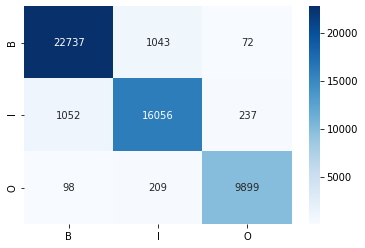

In [34]:
'''
Heap map output
'''

cf_matrix = confusion_matrix(actual_tags,predicted_tags)
#print(sns.heatmap(cf_matrix/np.sum(cf_matrix),xticklabels=['B', 'I','O'], yticklabels=['B','I','O'], annot=True,fmt='.2%', cmap='Blues'))
print(sns.heatmap(cf_matrix, annot=True,xticklabels=['B', 'I','O'], yticklabels=['B','I','O'],fmt="d", cmap='Blues'))

In [30]:
'''
Dumping the data for further analysis
'''

import pickle

with open('MEMM_actual_tags.pkl', 'wb') as f:
    pickle.dump(actual_tags, f)
    
with open('MEMM_predicted_tags.pkl', 'wb') as f:
    pickle.dump(predicted_tags, f)  
    
with open('MEMM_test_X.pkl', 'wb') as f:
    pickle.dump(test_sent_X, f)
    
with open('MEMM_test_Y.pkl', 'wb') as f:
    pickle.dump(test_sent_Y, f)
    
with open('MEMM_test_Y_pred.pkl', 'wb') as f:
    pickle.dump(predicted_tags_list, f)   
